<a href="https://colab.research.google.com/github/Shashank-Holla/TSAI-EVA4/blob/master/Sesssion5_MNIST/EVA4_S5_F2_SkeletalModel%26BatchNorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Target:

---
As previous model was over 20K, make the model lighter. Also added BatchNorm after every convolution to increase model efficiency.

Results:

---
1. Number of parameters: 6.6K
2. Training accuracy : 98.85%
3. Testing accuracy : 99.22%

Analysis:

---


1. Very light model. Scope to improve.
2. No overfitting. Test accuracy is a bit better than training accuracy. Shows model is trained harder. But model is not hitting required accuracy of 99.4%.

---



Importing Libraries

In [0]:
#A future statement is a directive to the compiler that a particular module should be compiled using syntax or semantics that will be available in a specified future release of Python.
from __future__ import print_function

# torch is the main module that holds all the things you need for Tensor computation.
import torch

# nn module provides many classes and functions to build neural networks.
# models, all kinds of layers, activation functions, parameter classes, etc
import torch.nn as nn

# functional api such as relu
import torch.nn.functional as F

# it offers all the optimizers like SGD, ADAM
import torch.optim as optim

#Torchvision is a package in the PyTorch library containing computer-vision models, datasets, and image transformations
from torchvision import datasets, transforms

#Matplotlib for graphs.
import matplotlib.pyplot as plt

Data Transformations

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      # transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Dataloader Arguments & Test/Train Dataloaders

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


The model

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #Convolution layer-1  
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8)                        
        ) #Output size- 28. RF=3

        #Convolution layer-2
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) #Output size- 28. RF=5

        #Max pool, Transition block and dropout - 1
        self.conv3 = nn.Sequential( 
            #Transition layer - start
            nn.MaxPool2d(2, 2), #Output size- 14. RF=6
            nn.Conv2d(16, 8, 1),  #Output size- 14. RF=6          
            nn.Dropout(0.25)
        ) 

        #Convolution Layer-3
        self.conv4 = nn.Sequential(
            nn.Conv2d(8, 8, 3, padding=1), #Output size- 14. RF=10 
            nn.ReLU(),
            nn.BatchNorm2d(8)             
        ) 
        
        #Convolution Layer-4
        self.conv5 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1), #Output size- 14. RF=14 
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )

        #Max pool, Transition block and dropout - 1
        self.conv6 = nn.Sequential(
            #Transition layer - start
            nn.MaxPool2d(2, 2), #Output size- 7. RF=16 
            nn.Conv2d(16, 8, 1), #Output size- 7. RF=16
            #Transition layer - End
            nn.Dropout(0.25)
        )

        #Convolution Layer-5
        self.conv7 = nn.Sequential(
            nn.Conv2d(8, 8, 3), #Output size- 5. RF=24
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )

        #Convolution layer-6
        self.conv8 = nn.Sequential(
           nn.Conv2d(8, 16, 3), #Output size- 3. RF=32
           nn.ReLU(),
           nn.BatchNorm2d(16)
        )

        #Final Layer
        self.conv9 = nn.Sequential(
           nn.Conv2d(16,10,3) #Output size- 1. RF=40
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
                      
        # Flatten layer
        x = x.view(-1, 10)
        return F.log_softmax(x)

Model Params

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
            Conv2d-4           [-1, 16, 28, 28]           1,168
              ReLU-5           [-1, 16, 28, 28]               0
       BatchNorm2d-6           [-1, 16, 28, 28]              32
         MaxPool2d-7           [-1, 16, 14, 14]               0
            Conv2d-8            [-1, 8, 14, 14]             136
           Dropout-9            [-1, 8, 14, 14]               0
           Conv2d-10            [-1, 8, 14, 14]             584
             ReLU-11            [-1, 8, 14, 14]               0
      BatchNorm2d-12            [-1, 8, 14, 14]              16
           Conv2d-13           [-1, 16, 14, 14]           1,168
             ReLU-14           [-1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training and Testing

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.11999378353357315 Batch_id=468 Accuracy=91.87: 100%|██████████| 469/469 [00:12<00:00, 38.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0877, Accuracy: 9729/10000 (97.29%)

EPOCH: 1


Loss=0.04888800159096718 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:12<00:00, 38.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9867/10000 (98.67%)

EPOCH: 2


Loss=0.022095700725913048 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:12<00:00, 38.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0417, Accuracy: 9868/10000 (98.68%)

EPOCH: 3


Loss=0.12609456479549408 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:12<00:00, 38.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9882/10000 (98.82%)

EPOCH: 4


Loss=0.012861703522503376 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:13<00:00, 35.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9897/10000 (98.97%)

EPOCH: 5


Loss=0.02301509492099285 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:12<00:00, 37.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9901/10000 (99.01%)

EPOCH: 6


Loss=0.059810247272253036 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:12<00:00, 37.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9879/10000 (98.79%)

EPOCH: 7


Loss=0.03515678644180298 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:12<00:00, 37.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9900/10000 (99.00%)

EPOCH: 8


Loss=0.018838325515389442 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:13<00:00, 34.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9906/10000 (99.06%)

EPOCH: 9


Loss=0.04083238169550896 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:13<00:00, 35.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9909/10000 (99.09%)

EPOCH: 10


Loss=0.019903922453522682 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:13<00:00, 34.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9907/10000 (99.07%)

EPOCH: 11


Loss=0.07652643322944641 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:13<00:00, 35.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9922/10000 (99.22%)

EPOCH: 12


Loss=0.004549875855445862 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:13<00:00, 35.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9922/10000 (99.22%)

EPOCH: 13


Loss=0.041571080684661865 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:13<00:00, 35.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9922/10000 (99.22%)

EPOCH: 14


Loss=0.0036130647640675306 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:13<00:00, 34.47it/s]



Test set: Average loss: 0.0196, Accuracy: 9935/10000 (99.35%)



Let's Train and test our model

Text(0.5, 1.0, 'Test Accuracy')

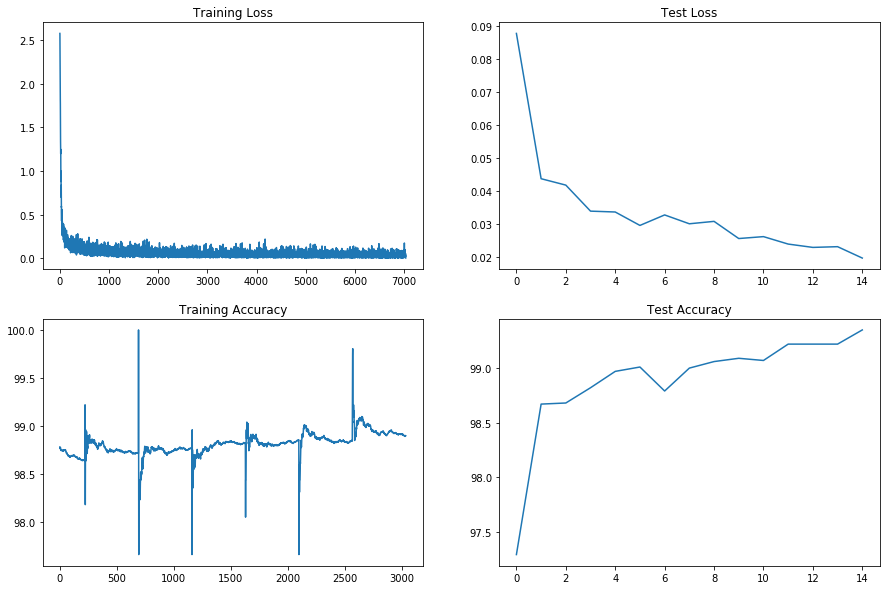

In [9]:
%matplotlib inline

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")